Basic classification of stadsarchief images
Network based on: https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

In [1]:
import numpy as np
import math
from PIL import Image
from scipy import misc
import keras.backend as K
from keras.applications.vgg16 import VGG16
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomUniform
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
 


from stats import list_stats
# from stats import show_train_curves
from data import load_data

Using TensorFlow backend.


In [2]:
# IMG_DIR = 'examples/0-src/200x200/';
# LABEL_DIR = 'examples/0-src/labels/';

img_dim = (100, 100, 3);
IMG_DIR = f'examples/0-src/beeldbank-scraped_set/{img_dim[0]}x{img_dim[1]}/'
LABEL_DIR = 'examples/0-src/beeldbank-scraped_set/labels/'


[X, Y_yaml] = load_data(IMG_DIR, LABEL_DIR)
Y_type = np.array([y.get('type') for y in Y_yaml])

def shuffle(X, Y):
    indices = np.random.permutation(X.shape[0])
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    return (X_shuffled, Y_shuffled)
# print(X.shape)

print('shuffling X and Y')
X_shuffled, Y_shuffled = shuffle(X, Y_type)
X = X_shuffled
Y_type = Y_shuffled

# def simplify_Y(Y):
#     return np.array([y if y == 'blueprint' else 'other' for y in Y])

# Y_type = simplify_Y(Y_type)

first few ids: ['000000091010', '000000091053', '000000091089', '000000091123', '000000091242']
shuffling X and Y


In [3]:
print(f"shape X: {X.shape}")
print(f"shape Y: {Y_type.shape}")

list_stats(Y_type)

shape X: (1201, 100, 100, 3)
shape Y: (1201,)
classes: 5
> 5 count classes: [['foto', 250], ['bouwtekening', 338], ['kaart', 30], ['affiche', 8], ['prent', 575]]
largest class: prent, count: 575
total count: 1201
score to beat: 0.4787676935886761


In [4]:
# Convert string to idx
types = list(set(Y_type))
num_classes = len(types)
print(f"number of classes: {num_classes}")
print(f"types encountered: {types}")

def convert_to_index(Y, types):
    return np.array([types.index(y) for y in Y])

Yind = convert_to_index(Y_type, types)
print(Y_type[:3])
print(Yind[:3])

list_stats(Yind)

number of classes: 5
types encountered: ['foto', 'bouwtekening', 'kaart', 'affiche', 'prent']
['foto' 'affiche' 'prent']
[0 3 4]
classes: 5
> 5 count classes: [[0, 250], [1, 338], [2, 30], [3, 8], [4, 575]]
largest class: 4, count: 575
total count: 1201
score to beat: 0.4787676935886761


In [5]:
# Rebalance
def rebalance(X, Yind):
    types = list(set(Yind))

    unique, counts = np.unique(Yind, return_counts=True)
    largest = max(counts)
    scaling = largest / counts
    return np.array(scaling)
scaling = rebalance(X, Yind)
print(scaling)

[ 2.3         1.70118343 19.16666667 71.875       1.        ]


In [6]:
# def set_class(Y, class_idx):
#     print(Y)
#     Y[:] = class_idx
#     print(Y)
#     return Y
# # YInd = set_class(Yind, 0)

In [7]:
Y = keras.utils.to_categorical(Yind, num_classes)  # convert class vectors to binary class matrices
print(Yind.shape)
print(Y.shape)
print(Y[:10])

scaling_matrix = np.tile(scaling, (X.shape[0], 1) )

Yscaled = Y * scaling_matrix
print(Yscaled[:10])

(1201,)
(1201, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
[[ 2.3         0.          0.          0.          0.        ]
 [ 0.          0.          0.         71.875       0.        ]
 [ 0.          0.          0.          0.          1.        ]
 [ 2.3         0.          0.          0.          0.        ]
 [ 2.3         0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.        ]
 [ 0.          0.         19.16666667  0.          0.        ]
 [ 0.          0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.          1.        ]
 [ 2.3         0.          0.          0.          0.        ]]


In [8]:
# Split to train and test
def split_data(X, Y, N):
    X_train = X[:N]
    Y_train = Y[:N]
    X_test = X[N:]
    Y_test = Y[N:]
    return (X_train, Y_train), (X_test, Y_test)

total = X.shape[0]
N = math.floor(0.8 * total)

(X_train, Y_train), (X_test, Y_test) = split_data(X, Yscaled, N)

print("")
print("split data shapes:")
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


split data shapes:
(960, 100, 100, 3)
(960, 5)
(241, 100, 100, 3)
(241, 5)


In [9]:
# resize = 40
# print("split data shapes:")
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)
# X_train = X_train[:, :resize, :resize, :]
# X_test = X_test[:, :resize, :resize, :]
# print("split data shapes:")
# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)
# img_dim = (resize, resize, 3);

In [39]:
# def build_model(num_classes, img_dim):
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=img_dim))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

def build_vgg16(num_classes, img_dim):
    assert(img_dim[0] == 224)
    assert(img_dim[1] == 224)
    assert(img_dim[2] == 3)
    # see https://keras.io/applications/#vgg16
    
    vgg16 = VGG16(
        include_top=False,
        input_shape=img_dim,
        weights='imagenet', # pre-trained on ImageNet
    )
    
    x = Flatten(name='flatten')(vgg16.layers[-2].output)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)

    #Then create the corresponding model 
    model = Model(input=vgg16.input, output=x)

    return model


def build_model(num_classes, img_dim):
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=img_dim,
#                      kernel_initializer = RandomUniform()
                    ))
    model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_dim))
    model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_initializer = RandomUniform()))
#     model.add(LeakyReLU())
#     model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def build_medium_size(num_classes, img_dim):
    # src: https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_dim))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# model = build_model(num_classes, img_dim)
# model = build_vgg16(num_classes, img_dim)
model = build_medium_size(num_classes, img_dim)
model.summary()

(100, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 64)        0      

In [11]:
def show_train_curves(history):
    """
    based on: https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
    """
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

In [ ]:
batch_size = 100
epochs = 50

# def mean_pred(y_true, y_pred):
#     return K.mean(y_pred)

datagen = ImageDataGenerator(
        zoom_range=0.1,        # randomly zoom into images
        rotation_range=5,      # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False    # randomly flip images
)
 
    
def compile_model(model):
    model.compile(
        loss='categorical_crossentropy',
#         loss=keras.losses.categorical_crossentropy,
#         optimizer=keras.optimizers.Adadelta(),
        optimizer='rmsprop',
#         optimizer=keras.optimizers.Adam(
#             lr=0.000003,
# #             lr=0.0003,
# #             lr=0.1,
# # #             epsilon=1e-6
#         ),        
        metrics=['accuracy']
    )

# def train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
#     compile_model(model)
#     history = model.fit(X_train, Y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               verbose=1,
#               validation_data=(X_test, Y_test)
#            )
#     return history
# history = train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)

def train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    history = model.fit_generator(
        datagen.flow(X_train,
                     Y_train,
                     batch_size=batch_size
        ),
        steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
        epochs=epochs,
        validation_data=(X_test, Y_test),
        workers=4
    )
    return history
history = train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)


show_train_curves(history)

Epoch 1/50
10/10 [==============================] - 29s 3s/step - loss: 32.1496 - acc: 0.4488 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 2/50
10/10 [==============================] - 28s 3s/step - loss: 31.2076 - acc: 0.4843 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 3/50
10/10 [==============================] - 26s 3s/step - loss: 31.1812 - acc: 0.4791 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 4/50
10/10 [==============================] - 28s 3s/step - loss: 31.3967 - acc: 0.4849 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 5/50
10/10 [==============================] - 27s 3s/step - loss: 32.3982 - acc: 0.4837 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 6/50
10/10 [==============================] - 27s 3s/step - loss: 32.2655 - acc: 0.4771 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 7/50
10/10 [==============================] - 27s 3s/step - loss: 30.9949 - acc: 0.4859 - val_loss: 27.9213 - val_acc: 0.4564
Epoch 8/50
10/10 [==============================] - 27s 3s/step - loss: 31.3

In [29]:
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train loss: 29.657943344116212
Train accuracy: 0.0125
Test loss: 24.20083161508394
Test accuracy: 0.02074688796680498


In [37]:
show_cnt = 30
print(f"types: {types}")

print("train predictions, truth")
predictions_train =  model.predict_classes(X_train)
print(predictions_train[:show_cnt])
print(np.argmax(Y_train, axis=1)[:show_cnt])

print("test predictions, truth")
print('[' + ' '.join(str(x)[-1:] for x in range(show_cnt)) )
predictions_test = model.predict_classes(X_test)
print(predictions_test[:show_cnt])
print(np.argmax(Y_test, axis=1)[:show_cnt])

types: ['foto', 'bouwtekening', 'kaart', 'affiche', 'prent']
train predictions, truth
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[0 3 4 0 0 4 2 4 4 0 4 1 0 0 4 0 4 4 1 0 0 1 0 4 1 1 0 0 4 0]
test predictions, truth
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[0 4 4 0 4 0 4 1 4 4 1 4 0 4 0 0 4 0 0 1 4 3 1 0 0 0 4 1 4 4]


In [15]:
def show_image(data, idx):
    image=X_train[idx, :, :, :]
#     print(image.shape)
#     img = Image.fromarray(image, 'RGB')
#     img.show()
    plt.axis("off")
    plt.imshow(image)
    plt.show()

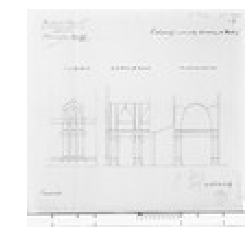

In [16]:
show_image(X_test, 11)

train set:
test set:


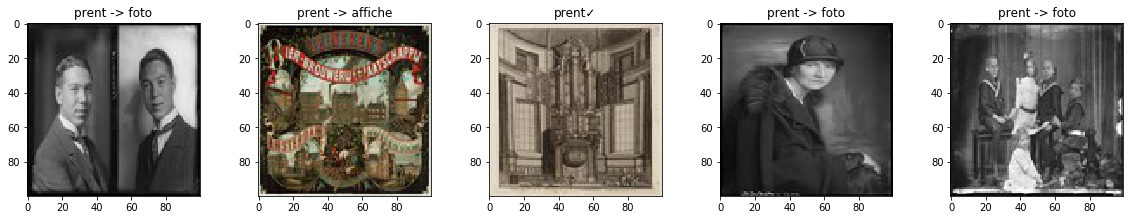

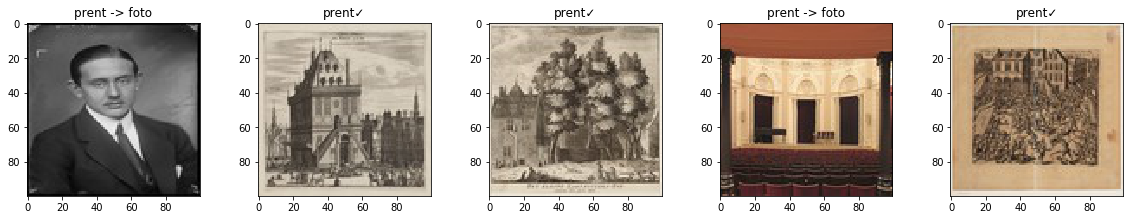

In [38]:
def show_predictions(X, Y, predictions, types, limit=3):
    columns = 5
    
    assert(predictions.shape[0] == Y.shape[0])
    plt.figure(figsize=(20, math.ceil(limit/columns) * 7) )

    images=X[:limit, :, :, :]
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        expected = types[Y[i]]
        prediction = types[predictions[i]]
        is_correct = expected == prediction
        if is_correct:
            plt.gca().set_title(f"{prediction}\u2713")
        else:
            plt.gca().set_title(f"{prediction} -> {expected}")
        plt.imshow(image)

Y_train_idx = np.argmax(Y_train, axis=1)        
Y_test_idx = np.argmax(Y_test, axis=1)


print("train set:")
show_predictions(X_train, Y_train_idx, predictions_train, types, 5)

print("test set:")
show_predictions(X_test, Y_test_idx, predictions_test, types, 5)
